In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout


In [3]:
import yfinance as yf
msft = yf.Ticker("MSFT")

In [11]:
df = msft.history(period="max")
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-11-02,204.289993,205.279999,200.119995,202.330002,30842200,0.0,0.0
2020-11-03,203.889999,208.119995,203.119995,206.429993,27512000,0.0,0.0
2020-11-04,214.020004,218.320007,212.419998,216.389999,42311800,0.0,0.0
2020-11-05,222.039993,224.119995,221.149994,223.289993,36080100,0.0,0.0
2020-11-06,222.259995,224.360001,218.029999,223.720001,25210600,0.0,0.0


In [12]:
df = df[['Close']].tail(1000)
df = df.set_index(pd.to_datetime(df.index))

In [13]:
df.head()

,Close
Date,
2016-11-17,57.003201
2016-11-18,56.730602
2016-11-21,57.210011
2016-11-22,57.454411
2016-11-23,56.777603


In [14]:
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df.head()

,Close
Date,
2016-11-17,0.007691
2016-11-18,0.006142
2016-11-21,0.008866
2016-11-22,0.010255
2016-11-23,0.006409


Text(0.5, 0, 'Date')

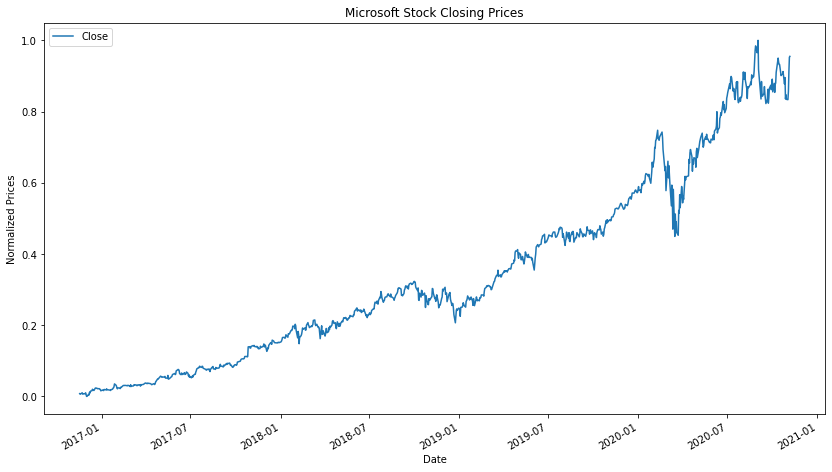

In [18]:
df.plot(figsize=(14,8))
plt.title('Microsoft Stock Closing Prices')
plt.ylabel('Normalized Prices')
plt.xlabel('Date')

In [19]:
def split_sequences(seq, n_steps_in, n_steps_out):
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
            
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [35]:
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(14,8))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    history = results.history
    plt.figure(figsize=(14,8))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc','acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [22]:
n_per_in = 60
n_per_out = 7
n_features = 1

X, y = split_sequences(list(df.Close), n_per_in, n_per_out)

print(X.shape)
X = X.reshape(X.shape[0], X.shape[1], n_features)
print(X.shape)

(934, 60)
(934, 60, 1)


In [26]:
model = Sequential()
model.add(LSTM(30, activation='softsign', return_sequences=True, input_shape=(n_per_in, n_features)))
model.add(LSTM(30, activation='softsign', return_sequences=True))
model.add(LSTM(30, activation='softsign', return_sequences=True))
model.add(LSTM(30, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign'))
model.add(Dense(n_per_out))

# model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1],1)))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=96))
# model.add(Dropout(0.2))
# model.add(Dense(units=1))

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 60, 30)            3840      
_________________________________________________________________
lstm_6 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 60, 30)            7320      
_________________________________________________________________
lstm_9 (LSTM)                (None, 10)                1640      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 77        
Total params: 27,517
Trainable params: 27,517
Non-trainable params: 0
__________________________________________________

In [29]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [30]:
result = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.1)

Train on 840 samples, validate on 94 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
840/840 [==============================] - 6s 7ms/sample - loss: 0.0966 - acc: 0.1571 - val_loss: 0.4359 - val_acc: 0.1277
Epoch 2/50
840/840 [==============================] - 4s 4ms/sample - loss: 0.0358 - acc: 0.1774 - val_loss: 0.1118 - val_acc: 0.1170
Epoch 3/50
840/840 [==============================] - 4s 4ms/sample - loss: 0.0054 - acc: 0.1464 - val_loss: 0.0334 - val_acc: 0.1277
Epoch 4/50
840/840 [==============================] - 3s 4ms/sample - loss: 0.0020 - acc: 0.1310 - val_loss: 0.0328 - val_acc: 0.2660
Epoch 5/50
840/840 [==============================] - 4s 4ms/sample - loss: 0.0016 - acc: 0.1393 - val_loss: 0.0300 - val_acc: 0.2766
Epoch 6/50
840/840 [==============================] - 4s 4ms/sample - loss: 0.0015 - acc: 0.1393 - val_loss: 0.0306 - val_acc: 0.2766
Epoch 7/50
840/840 [==============================] - 3s 

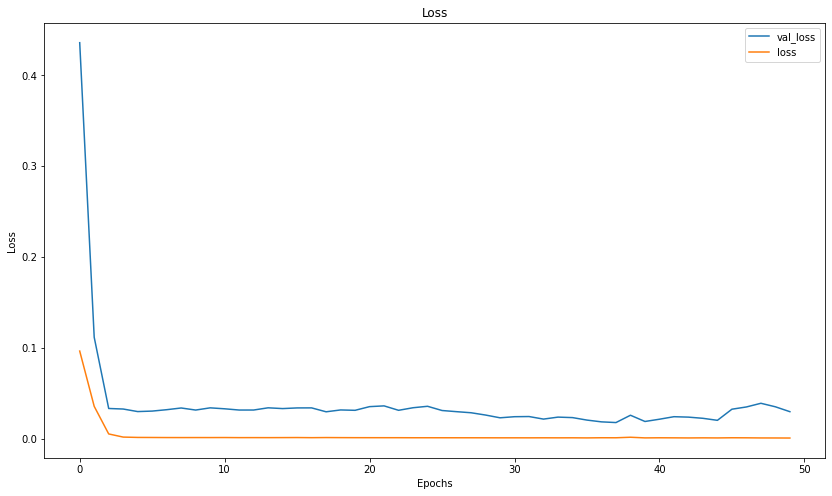

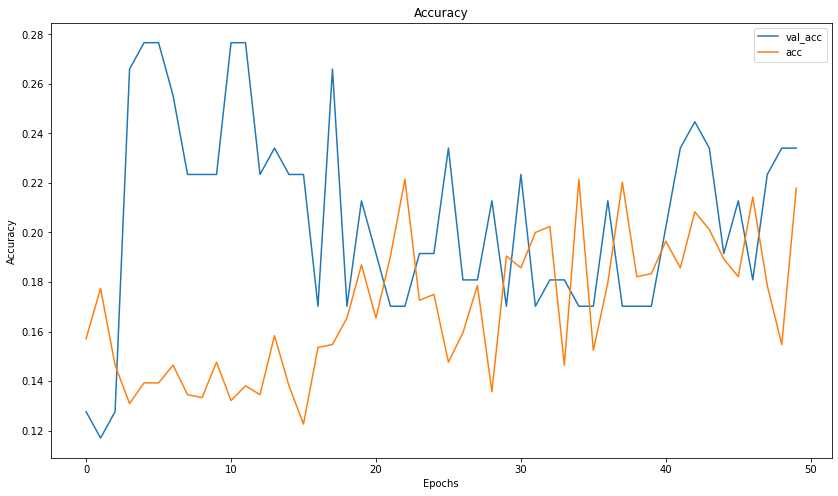

In [36]:
visualize_results(result)

predicted  [[190.94807097465286], [188.00108518785555], [187.06178139652616], [184.04908347368882], [181.9640344598149], [187.54540131727663], [186.17336674503235]]
actuals [[204.72000122070312], [202.47000122070312], [202.3300018310547], [206.42999267578122], [216.38999938964847], [223.2899932861328], [223.72000122070312]]


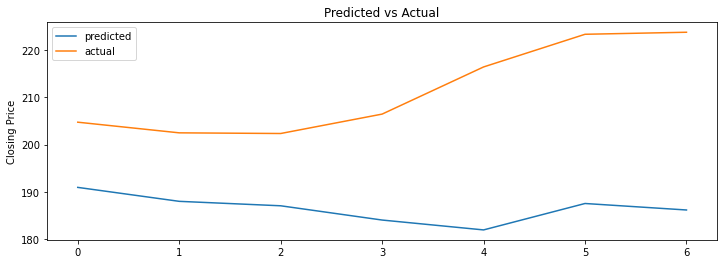

In [39]:
plt.figure(figsize=(12,4))

yhat = model.predict(X[-1].reshape(1,n_per_in,n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

actual = scaler.inverse_transform(y[-1].reshape(-1,1)).tolist()

print("predicted ", yhat)
plt.plot(yhat, label='predicted')
print("actuals", actual)
plt.plot(actual, label='actual')

plt.title("Predicted vs Actual")
plt.ylabel("Closing Price")
plt.legend()
plt.show()

                 Close
2020-11-06  223.720001
2020-11-07  217.206842
2020-11-08  217.724251
2020-11-09  221.277816
2020-11-10  220.690057
2020-11-11  221.978525
2020-11-12  224.267991
                 Close
Date                  
2020-10-29  204.720001
2020-10-30  202.470001
2020-11-02  202.330002
2020-11-03  206.429993
2020-11-04  216.389999
2020-11-05  223.289993
2020-11-06  223.720001


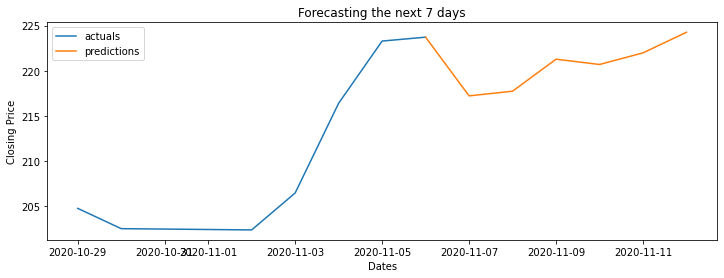

In [78]:
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1,n_per_in, n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

predictions = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat),freq='D'), columns=df.columns)
periods = n_per_out  #7 days
#actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)),index=df.Close.tail(periods).index, columns=df.columns).append(predictions.head(1))
actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)),index=df.Close.tail(periods).index, columns=df.columns)
predictions = predictions + (actual.tail(1)-predictions.head(1)).Close[0]
print(predictions)
print(actual)

plt.figure(figsize=(12,4))
plt.plot(actual, label='actuals')
plt.plot(predictions, label='predictions')
plt.ylabel('Closing Price')
plt.xlabel('Dates')
plt.title(f"Forecasting the next {periods} days")
plt.legend()
plt.show()